In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import photutils

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from astropy.stats import mad_std
from numpy.random import normal

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth




In [2]:
#Setup notebook so Tensorflow works in a friendly way in a shared multi GPU env

def setup_tensorflow(seed=None):
    try:
        import nvsmi
        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)


In [3]:
#If working in a multiply GPU setup run setup_tensorflow()

setup_tensorflow()

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-05-20 15:49:42.392885: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#load the image arrays, Size: (ngals, 64, 64), (2, ngals, 64, 64) respectively 

#Blends and components arrays are both noiseless

#Noise is then added to the blends which the network trains on

#Noiseless blends are used for the metrics 

components = np.load("c_isolatednew120k.npy")


In [5]:
def add_noise(img, scale=0.01):
    return img + normal(scale=scale, size=img.shape)

In [6]:
def asinh_scale(x, a=0.1, inverse=False):
    # This is a common way of scaling astronomical images
    # so that inner and outer regions of galaxies can be seen
    return np.arcsinh(x / a) / np.arcsinh(1 / a)

In [7]:
#Thresholding the masked areaas 


components[components<0] = -1*components[components<0]

components[components<22.3] = 22.3



In [8]:
#Scale the components 

components = asinh_scale(components)

#Then make the blends

blends = components[0] + components[1]

In [9]:
blends.shape, components.shape

((120000, 64, 64), (2, 120000, 64, 64))

In [10]:
np.mean(blends), np.mean(components)

(5.445390903568617, 2.72269545178434)

In [11]:
#Split into training and test set 

#Going to split training and test 80% and 20% respectively 

train_ngals = int(blends.shape[0] * 0.8)
test_ngals = int(blends.shape[0] * 0.2)

train_blends = blends[:train_ngals]
test_blends = blends[train_ngals:]

a, b, c, d, test_components = np.split(components, 5, axis = 1)

train_components = np.concatenate((a, b, c, d), axis = 1)






In [12]:
#Add noise to the training blends 

#Note we have split them up before encase later on we would like to change if our train / test blends have noise

train_blends = add_noise(train_blends)
test_blends = add_noise(test_blends)

In [13]:
#Now normalise based on maximum value of the arrays

norm_max = np.max([ np.max(train_blends), np.max(test_blends), np.max(train_components), np.max(test_components)])

train_blends /= norm_max
test_blends /= norm_max
train_components /= norm_max
test_components /= norm_max

In [14]:
train_components.shape, test_components.shape

((2, 96000, 64, 64), (2, 24000, 64, 64))

In [15]:
train_blends.shape, test_blends.shape

((96000, 64, 64), (24000, 64, 64))

In [16]:
np.amax(train_blends), np.amin(train_blends), np.amax(test_blends), np.amin(test_blends)

(1.0, 0.3631127382851077, 0.9695801835408829, 0.3631795403341737)

In [17]:
np.amax(test_components), np.amin(test_components), np.amax(test_blends), np.amin(test_blends)

(0.5293407041480852,
 0.1840219737835538,
 0.9695801835408829,
 0.3631795403341737)

In [18]:
height,width=64,64

train_blends = train_blends.reshape(train_ngals, height, width, 1).astype('float32')
train_components = train_components.reshape(2, train_ngals, height, width, 1).astype('float32')

test_blends = test_blends.reshape(test_ngals, height, width, 1).astype('float32')
test_components = test_components.reshape(2, test_ngals, height, width, 1).astype('float32')


In [19]:
batch_size = 32
latent_dimensions = 32

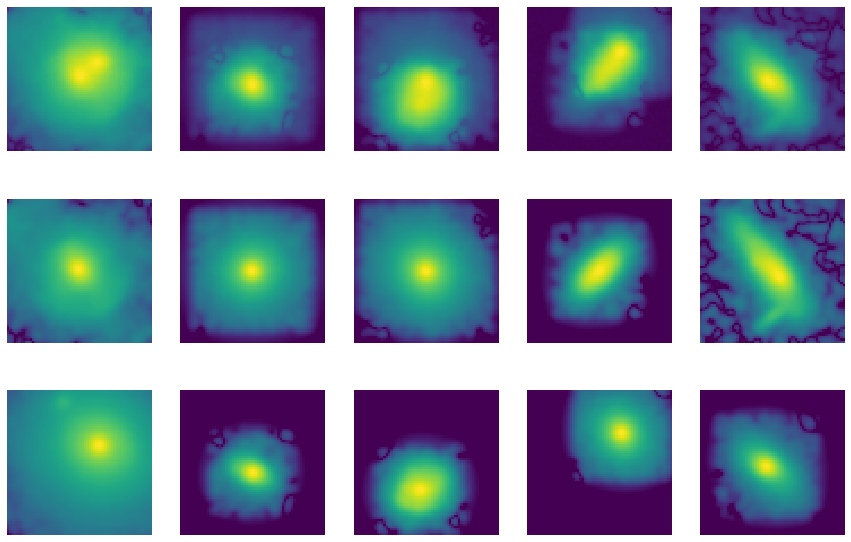

In [20]:
fig, ax = plt.subplots(train_components.shape[0] + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(train_blends[i], origin='lower', interpolation='nearest')
    ax[0, i].axis('off')
    ax[1, i].imshow(train_components[0, i], origin='lower', interpolation='nearest')
    ax[1, i].axis('off')
    ax[2, i].imshow(train_components[1, i], origin='lower', interpolation='nearest')
    ax[2, i].axis('off')

In [21]:
#Will optimise encoder / decoder later
def encoder(x):
    x = Conv2D(32,3,activation='relu',padding='same', strides=2)(x)
    x = Conv2D(64,3,activation='relu',padding='same', strides=2)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    return x

In [22]:
def decoder(x):
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(64,3,activation='relu',padding='same', strides=2)(x)
    x = Conv2DTranspose(32,3,activation='relu',padding='same', strides=2)(x)
    return x

In [23]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [24]:
# encoder
input_blend=Input(shape=(height, width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [25]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)


In [26]:
encode=Model(input_blend,z)
encode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['conv2d_1[0][0]']               
                                                                                              

In [27]:
input_component1 = Input(shape=(height, width, 1))

decode=Model([input_embed, input_component1], [output1])
decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 4096)         135168      ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 64)     0           ['dense_2[0][0]']                
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 16, 16, 64)   0           ['reshape[0][0]']                
                                                                                            

In [28]:
encoding = encode(input_blend)
re1 = decode([encoding, input_component1])

vae = Model([input_blend, input_component1], [re1])

In [29]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 32)           281024      ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 64, 64, 1)    190849      ['model[0][0]',                  
                                                                  'input_3[0][0]']          

In [30]:
#In our loss we are only going to compare to the central image i.e component 1 

mse_loss = tf.reduce_mean(mse(input_component1,re1)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

beta = 0.1 
kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')


train_together = [train_blends, train_components[0]]
test_together = [test_blends, test_components[0]]

#need an array which has the blends and both components for later use of calculating metrics - this will be using the test set 

metrics_together = [test_blends, test_components[0], test_components[1]]


vae.compile(optimizer=Adam())

In [31]:
val_split_ratio = 0.2
print(val_split_ratio * train_ngals)

19200.0


In [32]:
#training
history=vae.fit(train_together, verbose=1, epochs=100, batch_size=batch_size, validation_split = val_split_ratio)

Epoch 1/100
2400/2400 [==============================] - 34s 12ms/step - loss: 4.3936 - mse_loss: 4.2211 - kl_loss: 0.1725 - val_loss: 2.9077 - val_mse_loss: 2.7512 - val_kl_loss: 0.1566
Epoch 2/100
2400/2400 [==============================] - 27s 11ms/step - loss: 2.5737 - mse_loss: 2.4131 - kl_loss: 0.1606 - val_loss: 2.1433 - val_mse_loss: 1.9721 - val_kl_loss: 0.1712
Epoch 3/100
2400/2400 [==============================] - 26s 11ms/step - loss: 1.9351 - mse_loss: 1.7773 - kl_loss: 0.1578 - val_loss: 1.7396 - val_mse_loss: 1.5729 - val_kl_loss: 0.1667
Epoch 4/100
2400/2400 [==============================] - 27s 11ms/step - loss: 1.6562 - mse_loss: 1.4991 - kl_loss: 0.1571 - val_loss: 1.4909 - val_mse_loss: 1.3429 - val_kl_loss: 0.1480
Epoch 5/100
2400/2400 [==============================] - 27s 11ms/step - loss: 1.5095 - mse_loss: 1.3526 - kl_loss: 0.1569 - val_loss: 1.4470 - val_mse_loss: 1.2951 - val_kl_loss: 0.1519
Epoch 6/100
2400/2400 [==============================] - 29s 12ms

In [33]:
def histplot(history):
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = f'Minimum Validation Loss: {min(val_loss):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

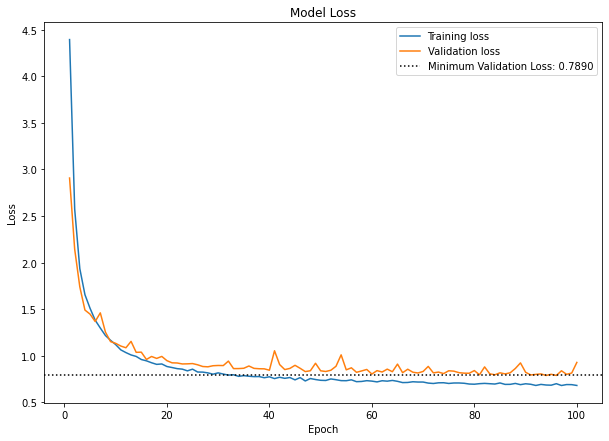

In [34]:
histplot(history)

In [35]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')



def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,comp1])
    comp1.shape, output_img.shape
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest')
        ax[0, i].set_title('In Blend')
        ax[0, i].axis('off')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest')
        ax[1, i].set_title('In Central Comp')
        ax[1, i].axis('off')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest')
        ax[2, i].set_title('In Comp 2')
        ax[2, i].axis('off')
        ax[3, i].imshow(output_img[i], origin='lower', interpolation='nearest')
        ax[3, i].set_title(f'Re Central Comp - SSIM: {ssim(output_img[i], comp1[i], channel_axis = 2, gaussian_weights = True, use_sample_covarience = False):.2f}')
        ax[3, i].axis('off')
        ax[4, i].imshow(input_img[i] - output_img[i], origin='lower', interpolation='nearest')
        ax[4, i].set_title(f'Re Residual Comp - SSIM: {ssim((input_img[i] - output_img[i]), comp2[i], channel_axis = 2, gaussian_weights = True, use_sample_covarience = False):.2f}')
        ax[4, i].axis('off')
        ax[5, i].imshow(abs(comp1[i] - output_img[i]), origin='lower', interpolation='nearest')
        ax[5, i].set_title('Re Comp Difference')
        ax[5, i].axis('off')
        plt.tight_layout()
    return idx


[ 6414 13523  8374  5256  4405]


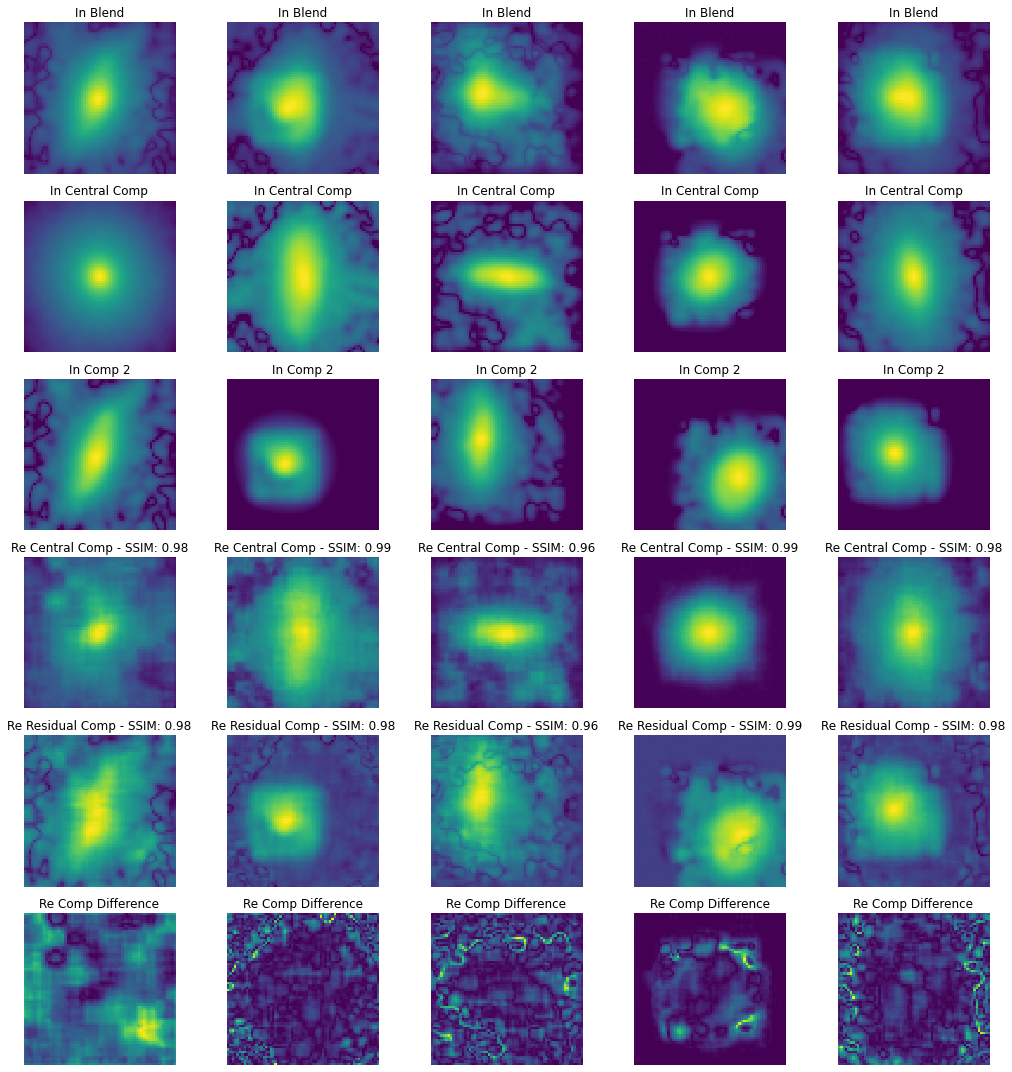

In [36]:
n=5
chosen=summary_plot(n,metrics_together,decode)

In [37]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(test_ngals)
    ssim_comp2 = np.zeros(test_ngals)
    ssim_blends = np.zeros(test_ngals)
    input_img = inputs[0]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1]
    comp2 = inputs[2]
    z = encode.predict(input_img)
    output_img1 = decode.predict([z, comp1])
    for i in range(test_ngals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis=2, gaussian_weights = True, use_sample_covarience = False)
        ssim_comp2[i] = ssim(comp2[i], (input_img[i] - output_img1[i]), channel_axis=2, gaussian_weights = True, use_sample_covarience = False)
 

    ssim_values = np.array([ssim_comp1, ssim_comp2])
    
    return ssim_values 
        
    
    

In [38]:
ssim_values = calc_ssim(metrics_together, decode)

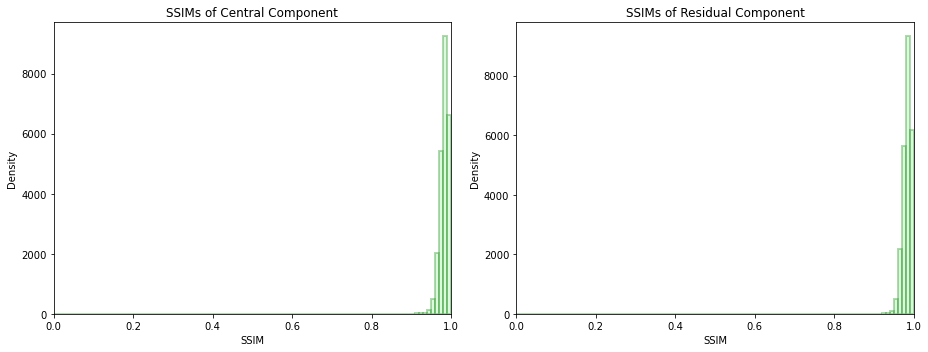

In [39]:
#Plot violinplots of the SSIM

n_of_bins = 100
bins = np.linspace(0,1,n_of_bins+1)

c = 'lightgreen'
outline = 'green'


fig, ax = plt.subplots(1, 2, figsize = (13,5))


vp1 = ax[0].hist(ssim_values[0], bins, color = c, ec = outline, alpha = 0.3, lw = 2)

ax[0].set_title('SSIMs of Central Component')
ax[0].set_xlabel('SSIM')
ax[0].set_ylabel('Density')

 

vp2 = ax[1].hist(ssim_values[1], bins,  color = c, ec = outline, alpha = 0.3, lw = 2)

ax[1].set_title('SSIMs of Residual Component')  
ax[1].set_xlabel('SSIM')
ax[1].set_ylabel('Density')
  
ax[0].set_xlim(0, 1) 
ax[1].set_xlim(0, 1) 
plt.tight_layout()

plt.show()

In [40]:
mean_ssim_comp1 = np.mean(ssim_values[0])
median_ssim_comp1 = np.median(ssim_values[0])
mean_ssim_comp2 = np.mean(ssim_values[1])
median_ssim_comp2 = np.median(ssim_values[1])

In [41]:
print(f' Mean SSIMs: Central Component: {mean_ssim_comp1:.4f}, Residual Component: {mean_ssim_comp2:.4f}')

print(f' Median SSIMs: Central Component: {median_ssim_comp1:.4f}, Residual Component: {median_ssim_comp2:.4f} ')

 Mean SSIMs: Central Component: 0.9827, Residual Component: 0.9823
 Median SSIMs: Central Component: 0.9847, Residual Component: 0.9842 


In [42]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(test_ngals)
    
    flux_in_comp1 = np.zeros(test_ngals)
    
    flux_out_comp1 = np.zeros(test_ngals)
    
    elip_in_comp1 = np.zeros(test_ngals)
    
    elip_out_comp1 = np.zeros(test_ngals)
    
    flux_in_comp2 = np.zeros(test_ngals)
    
    flux_out_comp2 = np.zeros(test_ngals)
    
    elip_in_comp2 = np.zeros(test_ngals)

    elip_out_comp2 = np.zeros(test_ngals)
    
    input_img = inputs[0]
    input_img = input_img.reshape(test_ngals, height, width)
    comp1 = inputs[1]
    comp1 = comp1.reshape(test_ngals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(test_ngals, height, width)
    
    z = encode.predict(input_img)
    output_img1 = decode.predict([z, comp1])
    output_img1 = output_img1.reshape(test_ngals, height, width)
    
    for i in range(test_ngals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
            
        out_comp2_cat = photutils.morphology.data_properties(input_img[i] - output_img1[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        parameters = [elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2]   
    return parameters


        

In [43]:
parameters = calc_properties(metrics_together, decode)

In [45]:
np.save("real_c_parameters.npy", parameters)